Shyam Kumar Ray Yadav (18449154)

Sonu Kumar (15651099)

Ahmad Raza Khawaja (25848862)

# Problem Sheet 2

## Exercise 2.1: algorithm runtimes.

The dataset stored in ```runtimes.csv``` contains information on the runtime of two algorithms (a serial version and a distributed version) on test problems of different size (measured in pixels), and for various numbers of worker threads (for the distributed version).



1. Create a chart that examines how fast runtime increases with problem size, for the single and distributed versions, and for different numbers of threads for the latter.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('runtimes.csv', comment = '#')
df

,size,workers,time,algo
0,4096,1,3.736606,distributed
1,4096,2,2.133074,distributed
2,4096,3,1.673441,distributed
3,4096,4,1.515788,distributed
4,4096,5,1.475265,distributed
5,16384,1,14.792794,distributed
6,16384,2,7.894031,distributed
7,16384,3,5.681171,distributed
8,16384,4,4.597697,distributed
9,16384,5,3.988286,distributed


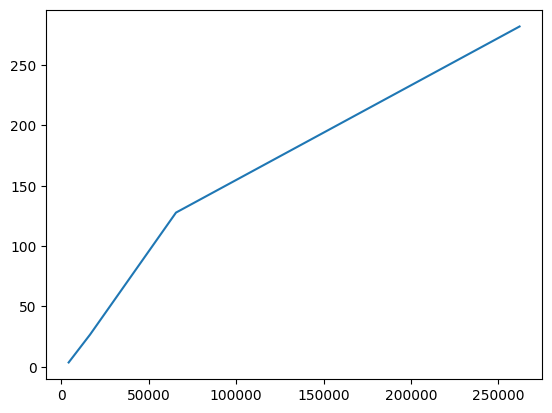

In [34]:
#Extracting the runtime and problem size of the serial algorithm. 
df_serial = df[df['algo'] == 'single'] 
serial_problem_size = df_serial['size']
serial_runtime = df_serial['time']
plt.plot(serial_problem_size, serial_runtime)


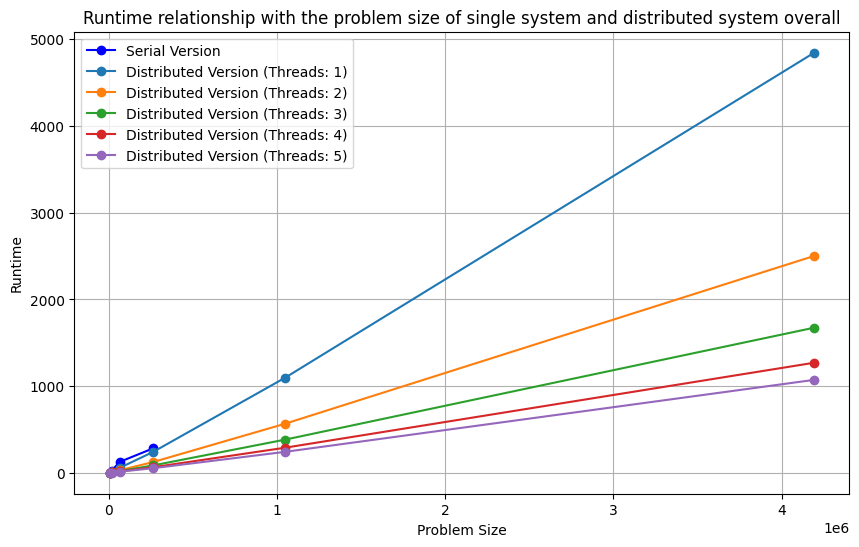

In [35]:
# Extract runtime values for the distributed algorithm with different number of threads
num_threads = df['workers'].unique()

# Create a separate line for each number of threads
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(serial_problem_size, serial_runtime, marker='o', linestyle = '-', color = 'b', label = 'Serial Version')

for num_thread in num_threads:
    df_distributed = df[(df['algo'] == 'distributed') & (df['workers'] == num_thread)]
    problem_sizes_distributed_thread = df_distributed['size']
    distributed_runtimes_thread = df_distributed['time']
    plt.plot(problem_sizes_distributed_thread, distributed_runtimes_thread, marker='o', linestyle='-', label=f'Distributed Version (Threads: {num_thread})')
    
plt.legend()
plt.xlabel('Problem Size')
plt.ylabel('Runtime')
plt.title('Runtime relationship with the problem size of single system and distributed system overall')
plt.grid(True)


2. Create a chart that examines how the runtime depends on the number of threads for the distributed version. What would be the ideal dependency? The chart should allow to compare the ideal case with the actual observations.


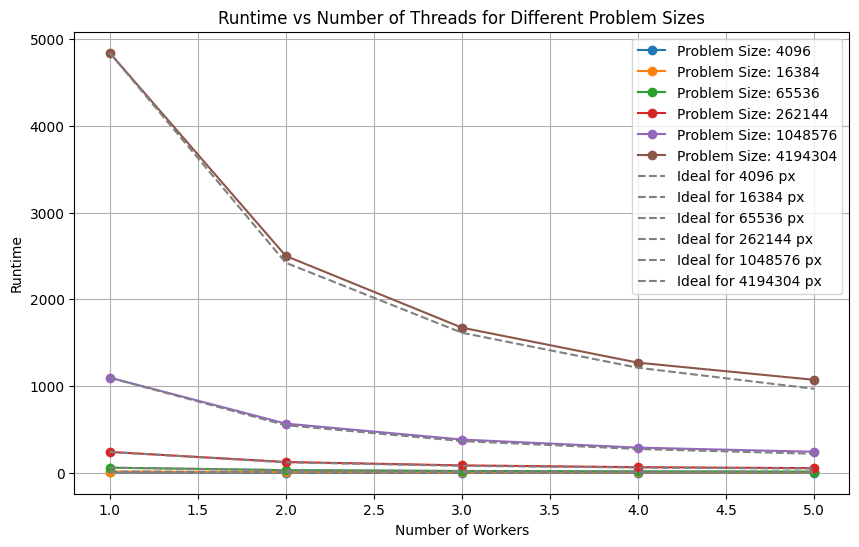

In [30]:
plt.figure(figsize=(10,6))
df_distributed = df[df['algo'] == 'distributed']
distributed_problem_size = df_distributed['size'].unique()

for d_size in distributed_problem_size:
    data_size = df_distributed[df_distributed['size'] == d_size]
    plt.plot(data_size['workers'], data_size['time'], marker = 'o', linestyle = '-', label = f'Problem Size: {d_size}')

# Recreate the DataFrame without the SettingWithCopyWarning
distributed_data_clean = df[df['algo'] == 'distributed'].copy()

# Calculate ideal times based on the baseline (1 worker) for each problem size
distributed_data_ideal = distributed_data_clean[distributed_data_clean['workers'] == 1]
distributed_data_ideal = distributed_data_ideal.set_index('size')
distributed_data_clean['ideal_time'] = distributed_data_clean.apply(
    lambda row: distributed_data_ideal.loc[row['size'], 'time'] / row['workers'], axis=1)


# Plot ideal times
for size in distributed_data_ideal.index.unique():
    workers = distributed_data_clean['workers'].unique()
    plt.plot(workers, distributed_data_ideal.loc[size, 'time'] / workers, label=f'Ideal for {size} px', linestyle='--', color='grey')

plt.xlabel('Number of Workers')
plt.ylabel('Runtime')
plt.title('Runtime vs Number of Threads for Different Problem Sizes')
plt.legend()
plt.grid(True)
plt.show()
    

So, the chart for the ideal dependency is also shown in the given code.

## Exercise 2.2: precipitation data.

In this exercise we process precipitation data of the Deutscher Wetterdienst (DWD). The original data is available at [https://www.dwd.de/DE/leistungen/cdc/cdc_ueberblick-klimadaten.html](https://www.dwd.de/DE/leistungen/cdc/cdc_ueberblick-klimadaten.html), but all data required for the exercise is already provided in the zip file of the problem sheet.

1. The file ```zehn_min_rr_Beschreibung_Stationen.txt``` (as available on the DWD website) contains basic information about the weather measurement stations. Its format should be self-explanatory. Convert it into reasonable CSV format. As a warmup, create a scatter plot of the geographical position of all weather stations and their elevation.

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


In [3]:
with open('zehn_min_rr_Beschreibung_Stationen.txt', 'r', encoding = 'latin-1') as textfile:
    lines = textfile.readlines()
    print(lines[0:25])


['Stations_id von_datum bis_datum Stationshoehe geoBreite geoLaenge Stationsname Bundesland\n', '----------- --------- --------- ------------- --------- --------- ----------------------------------------- ----------\n', '00020 20040812 20240422            432     48.9219    9.9129 Abtsgmünd-Untergröningen                                                         Baden-Württemberg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [4]:
#Since there are unwanted lines in the second row. We want to remove it. 
firstrow = lines[0].split()

#Creating empty list for reading lines and writing to CSV file later on.
data_collected = []

#Reading the data from the second row and storing it into given data.
for line in lines[2:]:
    rows = line.split(maxsplit = len(firstrow) -1)
    data_collected.append(rows)


In [5]:
#Now writing the collected data into the file.
with open('output.csv', 'w') as writefile:
    writer = csv.writer(writefile)
    writer.writerow(firstrow)
    writer.writerows(data_collected)

In [6]:
#readign the csv file and getting the dataframe:
df = pd.read_csv('output.csv')
df

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
0,20,20040812,20240422,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg ...
1,44,20070208,20240422,44,52.9336,8.2370,Großenkneten,Niedersachsen ...
2,53,20050831,20240422,60,52.5850,13.5634,Ahrensfelde,Brandenburg ...
3,73,20070213,20240422,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern ...
4,78,20041010,20240422,64,52.4853,7.9125,Alfhausen,Niedersachsen ...
...,...,...,...,...,...,...,...,...
1063,19172,20200820,20240422,48,54.0246,9.3880,Wacken,Schleswig-Holstein ...
1064,19207,20230330,20240422,16,53.8178,12.0645,Gülzow-Prüzen,Mecklenburg-Vorpommern ...
1065,19299,20210322,20240422,463,49.8713,11.7883,Speichersdorf,Bayern ...
1066,19897,20231231,20240422,37,52.5040,13.4550,Berlin-Friedrichshain-Nord,Berlin ...


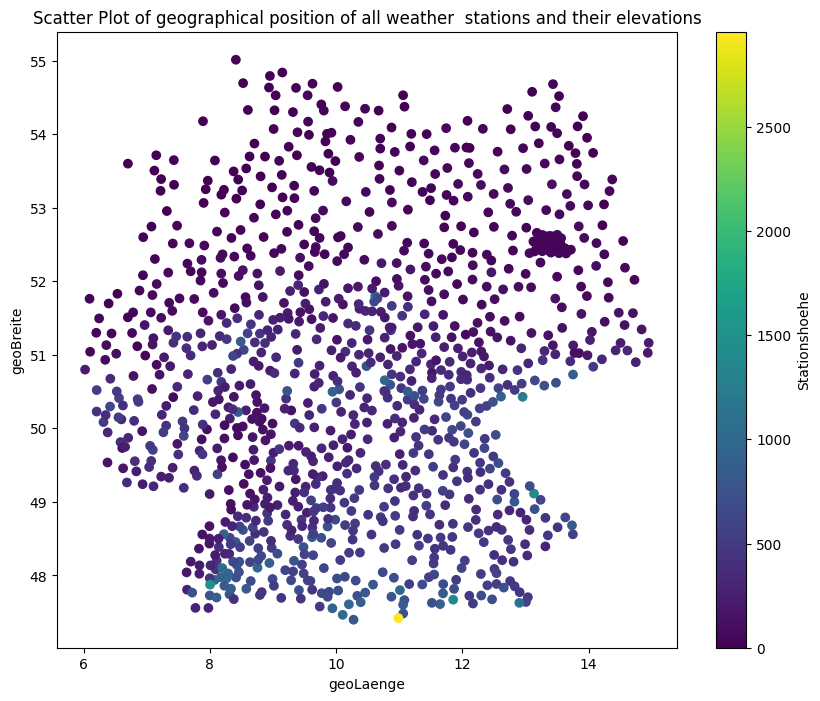

In [7]:
plt.figure(figsize = (10,8))
plt.scatter(df['geoLaenge'], df['geoBreite'], c = df['Stationshoehe'])
plt.xlabel('geoLaenge')
plt.ylabel('geoBreite')
plt.title('Scatter Plot of geographical position of all weather  stations and their elevations')
plt.colorbar(label = 'Stationshoehe')
plt.show()

2. The file ```10min_processed.csv``` contains condensed precipitation data for the day 2024- 04-20 in intervals of 10 minutes for (a subset of) the weather stations listed above. The column ```stationid``` corresponds to the column ```Stations_id``` in the other table. The column ```date``` indicates the beginning of the 10 minute interval in the format YYYYMMDDHHMM. The column ```rain``` encodes precipitation in this interval in millimeters, missing values are encoded as -999.


Compute the total precipitation at each weather station within each hour of the observed day. For one (or multiple) hours, show the precipitation of all weather stations in a scatter plot. Truncate missing values to zero.

In [8]:
df10min = pd.read_csv('10min_processed.csv')
df10min

,stationid,date,rain
0,6303,202404200000,0.0
1,6303,202404200010,0.0
2,6303,202404200020,0.0
3,6303,202404200030,0.0
4,6303,202404200040,0.0
...,...,...,...
150986,7429,202404202310,0.0
150987,7429,202404202320,0.0
150988,7429,202404202330,0.0
150989,7429,202404202340,0.0


In [9]:
df10min[90:110]

,stationid,date,rain
90,6303,202404201500,0.00
91,6303,202404201510,0.00
92,6303,202404201520,0.21
93,6303,202404201530,1.55
94,6303,202404201540,0.38
95,6303,202404201550,0.67
96,6303,202404201600,0.30
97,6303,202404201610,0.44
98,6303,202404201620,0.01
99,6303,202404201630,0.00


In [10]:
#Checking if there are missing values encoded as -999 in every column and entire data frame. 
has_minus = (df10min == -999).any().any()
has_minus

True

In [11]:
#Deleting or erasing the missing values encoded with -999.
df10min_cleaned = df10min.replace(-999, np.nan).dropna()

In [12]:
has_minus_cleaned = (df10min_cleaned == -999).any().any()
has_minus_cleaned

False

We want to calculate the total precipitation of each station within each hour (at 07, 15, and 23) on the 20th of April.

In [13]:
#Converting the date column to datetime
df10min_cleaned['date'] = pd.to_datetime(df10min_cleaned['date'], format = '%Y%m%d%H%M')
df10min_cleaned

,stationid,date,rain
0,6303,2024-04-20 00:00:00,0.0
1,6303,2024-04-20 00:10:00,0.0
2,6303,2024-04-20 00:20:00,0.0
3,6303,2024-04-20 00:30:00,0.0
4,6303,2024-04-20 00:40:00,0.0
...,...,...,...
150986,7429,2024-04-20 23:10:00,0.0
150987,7429,2024-04-20 23:20:00,0.0
150988,7429,2024-04-20 23:30:00,0.0
150989,7429,2024-04-20 23:40:00,0.0


In [14]:
#Extracting only hour from the date column and adding an additional hour column to dataframe.
df10min_cleaned['hour'] = df10min_cleaned['date'].dt.hour

In [15]:
#Grouping by station and hour, summing the precipitation column for individual hour.
hourly_precipitation = df10min_cleaned.groupby(['stationid','hour'])['rain'].sum().reset_index()
hourly_precipitation[:30]

,stationid,hour,rain
0,20,0,0.00
1,20,1,0.00
2,20,2,0.00
3,20,3,0.08
4,20,4,0.00
5,20,5,0.00
6,20,6,0.00
7,20,7,0.00
8,20,8,0.00
9,20,9,0.00


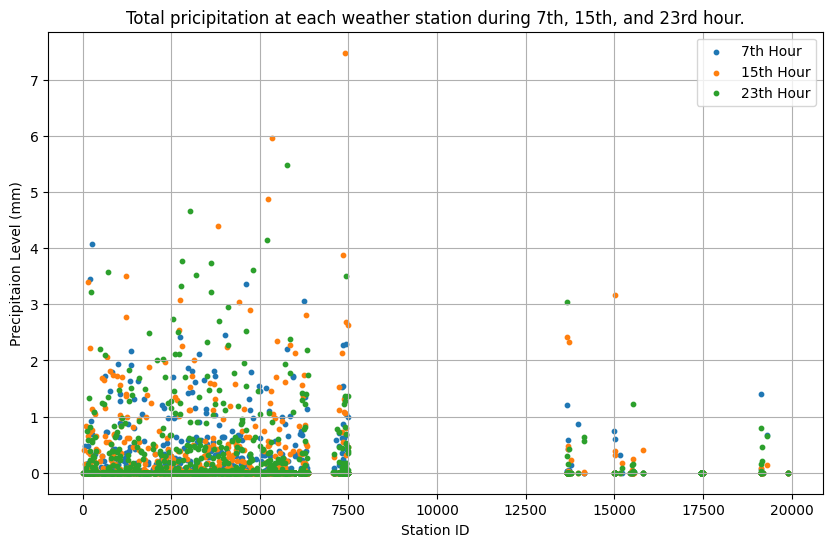

In [16]:
#Plotting hourly precipitaion for 3 different hours (7, 15, 23)

plt.figure(figsize = (10, 6))
desired_hours = [7, 15, 23]
for hours in desired_hours:
    precipitation_at_desired_hours = hourly_precipitation[hourly_precipitation['hour']==hours]
    plt.scatter(precipitation_at_desired_hours['stationid'], precipitation_at_desired_hours['rain'], label = f'{hours}th Hour', marker = 'o', s = 10)

plt.xlabel('Station ID')
plt.ylabel("Precipitaion Level (mm)")
plt.title("Total pricipitation at each weather station during 7th, 15th, and 23rd hour." )
plt.legend()
plt.grid(True)
# cb=plt.colorbar()
# cb.set_label('Hour')


3. The file ```griddata.npz``` contains the arrays ```geolat```, ```geolong``` and ```ind```. The two former arrays contain latitude and longitude positions of a regular rectangular Cartesian grid covering the measurement area, the third array contains an approximate binary indicator of the region covered by the measurements (with True indicating coverage). Interpolate the above precipitation data from the weather stations to this grid (only to the region indicated by ind) and display the data as an image. This gives a smoother visual impression of the geographical distribution of precipitation. Do this for all hours of the day as a small multiple.


In [17]:
#I will be solving this problem a bit later on. 